In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image # Import Pillow

In [11]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = "/content/drive/My Drive/MyFolder/Copy of Copy of devnagari digit.zip"
!unzip -q "/content/drive/My Drive/Copy of Copy of devnagari digit.zip" -d "/content/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Task 1: Data Preparation

Loading the Data

• Download the provided folder that contains the Devnagari digits dataset.

• Use the Python Imaging Library (PIL) to load and read the image files from the dataset.

• Convert the images into Numpy arrays and normalize them to a range of 0-1.

• use train folder for training and test for testing.

• Extract the corresponding labels for each image.

Hints:

• Ensure that the images are resized to a consistent shape (e.g., 28x28).
• Convert labels to one-hot encoded format for multi-class classification.

In [17]:
train_dir = "/content/DevanagariHandwrittenDigitDataset/Train"
test_dir = "/content/DevanagariHandwrittenDigitDataset/Test"

In [18]:


# Define image size
img_height, img_width = 28, 28

# Function to load images and labels
def load_images_from_folder(folder):
    images = []
    labels = []

    class_names = sorted(os.listdir(folder))  # Get sorted class names (e.g., digit_0, digit_1, ...)
    class_map = {name: i for i, name in enumerate(class_names)}  # Map class names to labels

    for class_name in class_names:
        class_path = os.path.join(folder, class_name)
        label = class_map[class_name]

        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)

            # Load image using PIL
            img = Image.open(img_path).convert("L")  # Convert to grayscale
            img = img.resize((img_width, img_height))  # Resize to (28,28)
            img = np.array(img) / 255.0  # Normalize pixel values to [0,1]

            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)


X_train, y_train = load_images_from_folder(train_dir)
X_test, y_test = load_images_from_folder(test_dir)


In [19]:
# Reshape data for TensorFlow (if needed for CNN input)
X_train = X_train.reshape(-1, img_height, img_width, 1)
X_test = X_test.reshape(-1, img_height, img_width, 1)

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Train data shape: (17000, 28, 28, 1)
Test data shape: (3000, 28, 28, 1)


# Task 2: Build the FCN Model

**Model Architecture**

• Create a Sequential model using Keras.

• Add 3 hidden layers with the following number of neurons:

– 1st hidden layer: 64 neurons

– 2nd hidden layer: 128 neurons

– 3rd hidden layer: 256 neurons

• Use sigmoid activation functions for all hidden layers.

• Add an output layer with 10 units with softmax (since Devnagari digits have 10 classes) and a
softmax activation function.

In [20]:
# Model parameters
import tensorflow as tf
from tensorflow import keras
num_classes = 10
input_shape = (28, 28, 1)
model = keras.Sequential(
[
keras.layers.Input(shape=input_shape),
keras.layers.Flatten(), # Flatten the 28x28 image to a 784-dimensional vector
keras.layers.Dense(64, activation="sigmoid"),
keras.layers.Dense(128, activation="sigmoid"),
keras.layers.Dense(256, activation="sigmoid"),
keras.layers.Dense(num_classes, activation="softmax"),
]
)


# Task 3: Compile the Model

**Model Compilation**

• Choose an appropriate optimizer (e.g., Adam), loss function (e.g., sparse categorical crossentropy),
and evaluation metric (e.g., accuracy).

In [21]:
model.compile(
optimizer="adam",
loss="categorical_crossentropy", # Loss function for multi-class classification
metrics=["accuracy"] # Track accuracy during training
)



# Task 4: Train the Model

**Model Training**

• Use the model.fit() function to train the model. Set the batch size to 128 and the number of
epochs to 700.

• Use validation split (validation split=0.2) to monitor the model’s performance on validation
data.

• Optionally, use callbacks such as ModelCheckpoint and EarlyStopping for saving the best model
and avoiding overfitting.

In [22]:
batch_size = 128  #Set batch size to 128
epochs = 700     #Set number of epochs to 700

#Callbacks for saving the best model & avoiding overfitting
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="best_model.keras", save_best_only=True),  # Saves only the best model
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)  # Stops early if no improvement
]

#Train the model with validation split = 0.2
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,  #Use 20% validation data
    callbacks=callbacks,
)


Epoch 1/700
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.3029 - loss: 1.9373 - val_accuracy: 0.0000e+00 - val_loss: 7.1314
Epoch 2/700
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8326 - loss: 0.5869 - val_accuracy: 0.0000e+00 - val_loss: 8.4618
Epoch 3/700
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9167 - loss: 0.2817 - val_accuracy: 0.0000e+00 - val_loss: 8.9208
Epoch 4/700
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9496 - loss: 0.1890 - val_accuracy: 0.0000e+00 - val_loss: 9.3795
Epoch 5/700
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9604 - loss: 0.1459 - val_accuracy: 0.0000e+00 - val_loss: 9.7445


# Task 5: Evaluate the Model

**Model Evaluation**

• After training, evaluate the model using model.evaluate() on the test set to check the test
accuracy and loss.

In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

94/94 - 0s - 2ms/step - accuracy: 0.6457 - loss: 2.0287
Test accuracy: 0.6457


# Task 6: Save and Load the Model

**Model Saving and Loading**

• Save the trained model to an .h5 file using model.save().

• Load the saved model and re-evaluate its performance on the test set.

In [24]:
from google.colab import drive
drive.mount('/content/drive')

# Save to Google Drive
model.save('/content/drive/My Drive/SilashChaudhary.h5')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
loaded_model = tf.keras.models.load_model('/content/drive/My Drive/SilashChaudhary.h5')
print("Model loaded from Google Drive successfully!")

Model loaded from Google Drive successfully!


In [26]:
test_loss, test_acc = loaded_model.evaluate(X_test, y_test, batch_size=128)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8055 - loss: 0.9118
Test Accuracy: 0.6457
Test Loss: 2.0287


# Task 7: Predictions

**Making Predictions**

• Use model.predict() to make predictions on test images.

• Convert the model’s predicted probabilities to digit labels using np.argmax().

In [27]:
predictions = loaded_model.predict(X_test)  # Make predictions on test data
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

# Print first 5 predictions
print("First 5 Predicted Labels:", predicted_labels[:5])
print("First 5 True Labels:", y_test[:5])


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
First 5 Predicted Labels: [7 7 0 0 0]
First 5 True Labels: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


**Expected Deliverables**

• Code Implementation: Complete code for building, training, evaluating, saving, and loading
the model.

• Visualization: Graphs showing the training and validation loss and accuracy.

• Test Accuracy: Display the final test accuracy.

• Saved Model: Submit the saved .h5 model file.

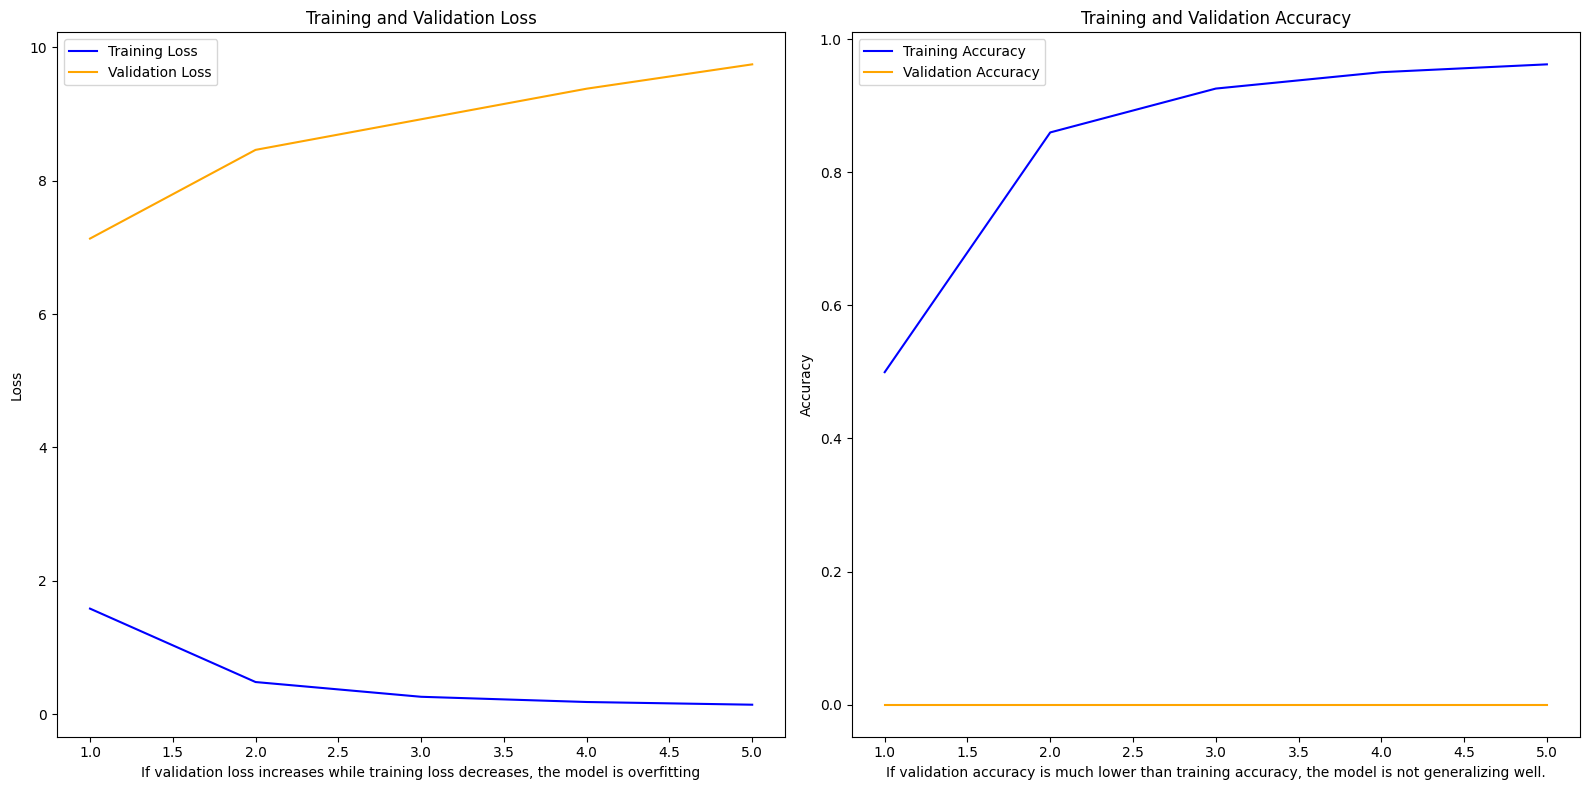

In [28]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()
# Extracting training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extracting training and validation accuracy (if metrics were specified)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting training and validation loss
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.xlabel('If validation loss increases while training loss decreases, the model is overfitting')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy', color='blue')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.xlabel('If validation accuracy is much lower than training accuracy, the model is not generalizing well.')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



# Display a Few Sample Predictions

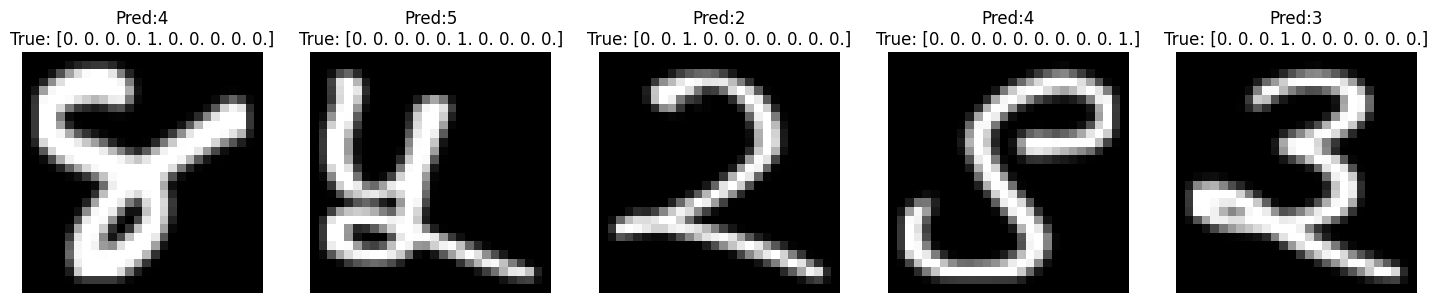

In [29]:
import random

# Select random images from test set
num_samples = 5
random_indices = random.sample(range(len(X_test)), num_samples)

plt.figure(figsize=(18, 9))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(X_test[idx], cmap="gray")  # Show the test image

    plt.title(f"Pred:{predicted_labels[idx]}\nTrue: {y_test[idx]}")
    plt.axis('off')

plt.show()
